# PINN approaches to solve the Matern SPDE

*Lucia Clarotto, Hugo Gangloff, Nicolas Jouvin, May 2024*

In this notebook we propose to solve the Matern SPDE

$$
(\kappa^2 - \Delta)^{\alpha/2} \mathcal{U} = \mathcal{W},
$$

using the classical PINN framework in which we minimize the loss

$$
\mathcal{L}_{PDE}(\theta) = \frac{1}{n}\sum_{i=1}^{n}  \vert \mathcal{N}[u_\theta]({s}_i) - w\vert^2 ,
$$
with $\mathcal{N}[u_\theta] :=(\kappa^2 - \Delta)^{\alpha/2} u_\theta$.

We compare 3 architectures for $u_\theta$:
1. spectralPINN
2. sinusPINN
3. classical PINN

All the parameters of the equation are supposed to be known ($\tau$, $\alpha$) and the white noise realization $w$ is fixed and known too.

Our reference simulation $u_{\mathrm{spectral}}$ is performed using the spectral method from which we need to recover the white noise term. We will do so by using the fact that the differential operator applied to the solution must produce the white noise term, i.e. $w=(\kappa^2 - \Delta)^{\alpha/2} u_{\mathrm{spectral}}$


## Set up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # Disable GPU

In [3]:
import jinns
import numpy as onp
import equinox as eqx
import jax
from jax import random
from jax import jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time
import numpy as np

In [4]:
key = random.PRNGKey(2)
key, subkey = random.split(key)

## Sampling with spectral method
The method is described in Denis Allard et al. _Simulating space-time random fields with nonseparable Gneiting-type covariance functions_, 2020.
Note that we add a filtering for the highest variances. Without this, we would have strong artifacts altering the quality of the initialisation of the spectralPINN!

In [5]:
# Number of bands
nb = 5000
# scale parameter
kappa = scale = 0.3

# # Matern smoothness
d = k = 2
alpha = 2 # current expression of the spde
nu = alpha - d / 2
sigma = 1 / jnp.sqrt(4 * jnp.pi * kappa ** 2)
print(sigma)

0.940316


In [6]:
def simSpectralSpatial_no_high_freq(key, nb = 1, nu = 1):
    subkey = jax.random.split(key,3)
    quantile = 0.95
    n_sample = int(nb*(1+2*(1-quantile)))
    gamma = jax.random.gamma(key = subkey[0], a=nu, shape=(n_sample,))*2/kappa**2
    xi = 1/(2*gamma)
    multR_plus = jnp.sqrt(2*xi)
    threshold = jnp.quantile(multR_plus,quantile)
    multR = multR_plus[multR_plus < threshold]
    omega = multR[:nb]*jax.random.normal(key = subkey[1], shape=(k,nb))
    #omega = multR_plus*jax.random.normal(key = subkey[1], shape=(k,nb))

    phi = 2*jnp.pi*jax.random.uniform(key = subkey[2], shape=(nb,))
    return omega,phi
def simulate_one(omega,phi,xy,kappa):
    temp = jnp.exp(1j * (omega.T @ xy + phi))
    return sigma * jnp.sqrt(2/nb) * jnp.sum(jnp.real(temp),axis=0) # NOTE the sigma
def simulate_wn_one(omega,phi,xy,kappa):
    return sigma * jnp.sqrt(2/nb) * jnp.sum( (kappa ** 2 + jnp.linalg.norm(omega,axis=0) ** 2) * jnp.cos(omega.T @ xy + phi)) # NOTE the sigma

In [7]:
true_omega, true_phi = simSpectralSpatial_no_high_freq(subkey, nb=nb, nu=nu)

## Source term (white noise) simulation

Note about the `practical_range`: we train on a larger domain to avoid boundary effects polluting the results (see an extended discussion of the phenomenon in Khristenko et al., _Analysis of boundary effects on PDE-based sampling of Whittle-Matérn random fields_, 2018)

In [8]:
lx = ly = 64 - 1
xmin = 0
xmax = 64 - 1
ymin = 0
ymax = 64 - 1
nx, ny = 64, 64
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

In [9]:
practical_range = int(np.round(jnp.sqrt(8 * nu) / kappa))
shape = (xmax + 1 + 4 * practical_range, ymax + 1 + 4 * (practical_range))
source_term = jax.random.normal(key=subkey, shape=shape)

## Sampling with finite differences

Below we perform the actual simulation of the field with Matern covariance on the desired domain with the true parameters that we simulated. This is our **target field**

In [10]:
import numpy as np
import math
import numpy.typing as npt
from scipy.special import kv
from scipy.spatial import distance_matrix
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import LinearOperator, gmres, splu
import matplotlib.pyplot as plt

NDArrayFloat = npt.NDArray[np.float64]


def get_laplacian_matrix(
    nx: int, ny: int, dx: float, dy: float, kappa: float
) -> csc_matrix:
    """
    Return a sparse matrix of the discretization of the Laplacian.

    Parameters
    ----------
    nx : int
        Number of meshes along x.
    ny : int
        Number of meshes along y.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    kappa : float
        Range (length scale).

    Returns
    -------
    csc_matrix
        Sparse matrix with dimension (nx * ny)x(nx * ny) representing the  discretized
        laplacian.

    """
    n_nodes = nx * ny

    # construct an empty sparse matrix (lil_format because it supports indexing and
    # slicing).
    lap = lil_matrix((n_nodes, n_nodes), dtype=np.float64)

    # Looping on all nodes and considering neighboors
    for i in range(nx):
        for j in range(ny):
            node_index = i * ny + j
            lap[node_index, node_index] += kappa**2 + 2 / dx**2 + 2 / dx**2
            if i > 0:
                neighbor_index = (i - 1) * ny + j
                lap[node_index, neighbor_index] += -1.0 / dx**2
            if i < nx - 1:
                neighbor_index = (i + 1) * ny + j
                lap[node_index, neighbor_index] += -1.0 / dx**2
            if j > 0:
                neighbor_index = i * ny + (j - 1)
                lap[node_index, neighbor_index] += -1.0 / dy**2
            if j < ny - 1:
                neighbor_index = i * ny + (j + 1)
                lap[node_index, neighbor_index] += -1.0 / dy**2

    # Convert from lil to csr matrix for more efficient calculation
    return lap.tocsc()


def get_preconditioner(mat: csc_matrix) -> LinearOperator:
    """Get the preconditioner for the given matrix."""
    op = splu(mat)

    def super_lu(x):
        return op.solve(x)

    return LinearOperator(mat.shape, super_lu)


def simu_nc(
    lap_mat: csc_matrix, dx: float, dy: float, wn: NDArrayFloat
) -> NDArrayFloat:
    """
    Return the gaussian solution of the discretized EDPS (gaussian vector).

    Parameters
    ----------
    lap_mat : csc_matrix
        The laplacian matrix.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    wn : white noise
    Returns
    -------
    NDArrayFloat
        The simulation.

    """
    # Fonctions R utiles: ncol, rnorm, solve

    # white noise with size nx * ny -> standard deviation np.sqrt(1 / (dx*dy) ) 
    w = np.sqrt(1 / (dx*dy))*wn

    # Use a LU preconditioner to get faster computation
    z, info = gmres(lap_mat, w, M=get_preconditioner(lap_mat), atol=1e10)

    #tau = kappa * np.sqrt((4 * np.pi * math.gamma(2) / math.gamma(1)))
    return z #* tau

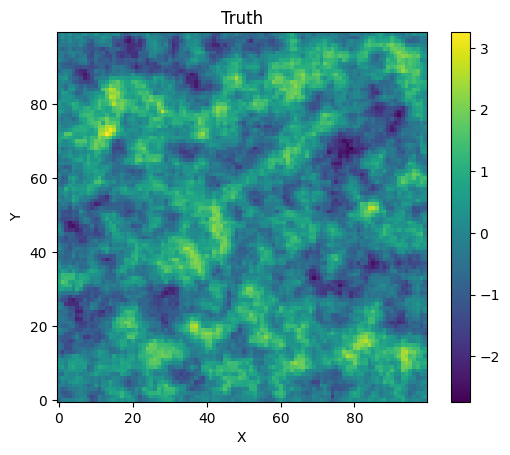

In [11]:
nx = ny = shape[0]  # grid size definition (meshes)
n_nodes = nx * ny  # number of meshes
dx = dy = 1  # mesh size
kappa = 0.3  # length scale

# Build the laplacian matric
simu_lap_mat = get_laplacian_matrix(nx, ny, dx, dy, kappa)

# Set a random number generator to obtain reproducible results
# Generate a seed from a cool sentence
# Note: this is an incremental generator
# rng = np.random.default_rng(np.abs(hash("mike is the best")))
# wn = rng.normal(loc=0, scale=1, size=simu_lap_mat.shape[0])
wn = np.asarray(source_term.flatten())

# Non conditional simulation with a given seed for the white noise
Y = jnp.asarray(simu_nc(simu_lap_mat, dx, dy, wn).reshape(ny, nx, order='F').T)

#plt.imshow(simu_lap_mat.todense())
#plt.show()

# Display the simulated field
plt.imshow(Y, origin="lower")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Truth")
plt.colorbar()
plt.show()

## Solving the Matern SPDE in the PINN framework

Create train dataset and validation dataset with **jinns**. Note that we only train and validate on integer values where the source term is available.

In [12]:
n = 19600
batch_size = 1024
method = 'grid'

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    subkey, n, None, batch_size, None, 2,
    (xmin-(2*practical_range), ymin-(2*(practical_range))), (xmax+(2*practical_range)+1, ymax+(2*practical_range)+1),
    # +1 because of arange in DataGenerator
    method=method
)
train_data.omega = jnp.round(train_data.omega).astype(float)

In order to compute the error on the interior domain of interest (to avoid boundary effects) we resort to **jinns**' validation module

In [13]:
n = (xmax+1) * (ymax+1)
batch_size = (xmax+1) * (ymax+1)
method = 'grid'

key, subkey = random.split(key)
validation_data = jinns.data.CubicMeshPDEStatio(
    subkey, n, None, batch_size, None, 2, (xmin, ymin), (xmax+1, ymax+1), method=method
    # +1 because of arange in DataGenerator
)
validation_data.get_batch()
validation_data.omega = jnp.round(validation_data.omega).astype(float)

Create the PINN losses in **jinns**

In [14]:
from jinns.loss import PDEStatio

def _laplacian_fwd(x, u, params):
    """
    We compute the Laplacian in a forward manner
    """
    return jnp.trace(jax.jacfwd(jax.jacfwd(lambda x: u(x, params)[..., 0]))(x))


class Matern_SPDE_Statio(PDEStatio):
    def __init__(self, eq_params_heterogeneity=None):
        super().__init__(eq_params_heterogeneity)

    #@PDEStatio.evaluate_heterogeneous_parameters
    def evaluate(self, x, u, params):
        lap = _laplacian_fwd(x, u, params)
        source_term = params["eq_params"]["source_term"]
        kappa = params["eq_params"]["kappa"]
        return (
            lap
            + source_term[jnp.round(x[0]).astype(jnp.int32)+2*(practical_range),
                            jnp.round(x[1]).astype(jnp.int32)+2*(practical_range)]
            - kappa**2 * u(x, params["nn_params"])
        )
dynamic_loss = Matern_SPDE_Statio(
    #eq_params_heterogeneity={"source_term":Lu},
)


**1) Spectral PINN**

In [15]:
nbands = 5000
list_layers_pinn = [
    [eqx.nn.Linear, 2, nbands],
    [jnp.cos]
]

key, subkey = random.split(key)
spectralPINN = jinns.experimental.create_spectralPINN(subkey, list_layers_pinn, nbands)
init_nn_params = spectralPINN.init_params()

Set up the loss in **jinns**

In [16]:
loss_weights = {"dyn_loss":1}

loss = jinns.loss.LossPDEStatio(
    u=spectralPINN,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss
)


/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


**jinns** set up for validation loss: to compute the loss avoiding boundary effects

In [17]:
from jinns.validation import ValidationLoss
validation = ValidationLoss(
    loss = loss, # a deep copy of `loss` will be done internally
    validation_data = validation_data,
    validation_param_data = None,
    validation_obs_data = None,
    call_every=250,
    early_stopping=True,
    patience=20
)

In [18]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "kappa":scale,
        "source_term":source_term.T #0. # will be replaced by a function #jnp.asarray(source_term)
    }
}

Initialise the parameters with samples from the true distribution.

**Note** that this is important to cut off high frequencies here!

In [19]:
key, subkey = jax.random.split(key)
init_omega, init_phi=simSpectralSpatial_no_high_freq(subkey, nb = nb, nu = nu)

init_params["nn_params"] = eqx.tree_at(lambda m: m.layers_pinn[0].weight, init_params["nn_params"], init_omega.T)
init_params["nn_params"] = eqx.tree_at(lambda m: m.layers_pinn[0].bias, init_params["nn_params"], init_phi)

We look at the initialization of the spectralPINN on the domain of interest below. Obviously, as we consider the parameters to be known, the initialization has the same general appearance as the target field, but it is definitly different!

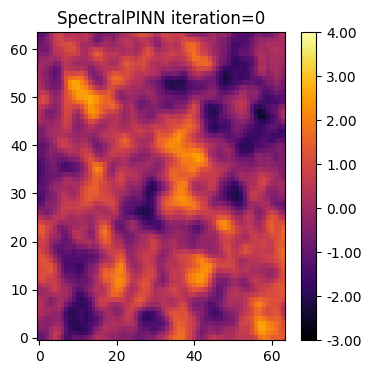

In [20]:
spectralPINN_init = lambda x: spectralPINN(x, init_params["nn_params"])
jinns.data.plot2d(
    spectralPINN_init,
    xy_data = val_xy_data,
    title="SpectralPINN iteration=0",
    vmin_vmax=(-3, 4),
    figsize=(4, 4)
)

## Training

The actual training loop now arrives

In [21]:
params = init_params

In [22]:
# Optimizer
import optax

tx = optax.adam(learning_rate=5e-4)
n_iter = int(50000)

In [23]:
start = time.time()
params_spectralPINN, train_loss_values, loss_by_term_dict, train_data, loss, _, _, validation_loss_values = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=5000,
    validation=validation
)
end = time.time()
time_spectralPINN = int(end - start)

/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/rech

[train] Iteration 0: loss value = 1.417264699935913
[validation] Iteration 0: loss value = 1.3714333772659302
[train] Iteration 5000: loss value = 1.004518747329712
[validation] Iteration 5000: loss value = 1.0641977787017822
[train] Iteration 10000: loss value = 0.9193930625915527
[validation] Iteration 10000: loss value = 1.0529636144638062
[train] Iteration 15000: loss value = 0.8627318143844604
[validation] Iteration 15000: loss value = 1.0395870208740234
[train] Iteration 20000: loss value = 0.9233042001724243
[validation] Iteration 20000: loss value = 1.0370631217956543
[train] Iteration 25000: loss value = 0.8747091293334961
[validation] Iteration 25000: loss value = 1.0334053039550781
[train] Iteration 30000: loss value = 0.9363369941711426
[validation] Iteration 30000: loss value = 1.0291011333465576
[train] Iteration 35000: loss value = 0.924534261226654
[validation] Iteration 35000: loss value = 1.0284771919250488
[train] Iteration 40000: loss value = 0.8814072608947754
[val

/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


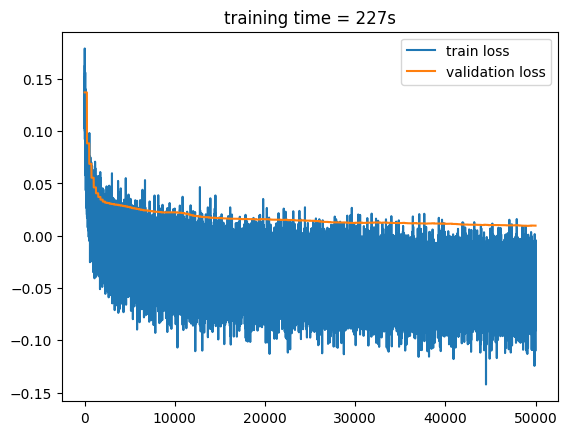

In [24]:
plt.plot(jnp.log10(train_loss_values), label="train loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.title(f"training time = {time_spectralPINN}s")
plt.legend()
plt.show()

In [25]:
spectralPINN_est = lambda x: spectralPINN(x, params_spectralPINN["nn_params"])

In [26]:
u_diff = lambda x: (Y[jnp.round(x[1]).astype(jnp.int32)+2*(practical_range),
                            jnp.round(x[0]).astype(jnp.int32)+2*(practical_range)] - spectralPINN_est(x)) ** 2

train_xy_data = [jnp.linspace(xmin-2*(practical_range), xmax+2*(practical_range), nx+4*(practical_range)),
               jnp.linspace(ymin-2*(practical_range), ymax+2*(practical_range), ny+4*(practical_range))
              ]
mesh = jnp.meshgrid(val_xy_data[0],val_xy_data[1])
coords = jnp.vstack([mesh[0].flatten(), mesh[1].flatten()]).T
mse = jnp.mean(jax.vmap(u_diff)(coords))

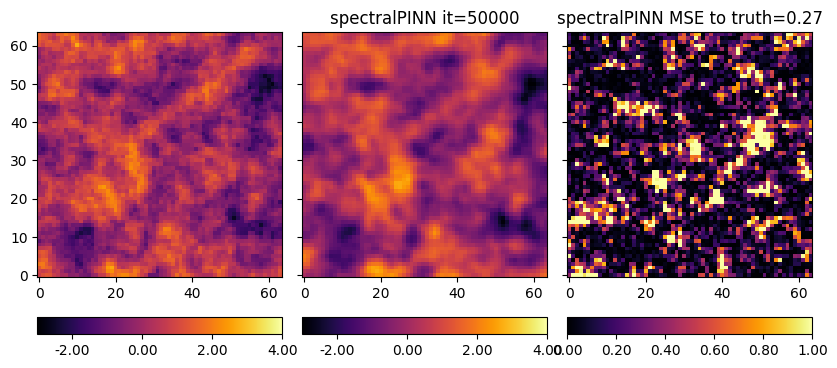

In [27]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 10))
axes = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 3),
    axes_pad=0.2,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4
)

im = axes[0].imshow(Y[2*(practical_range):-2*(practical_range),2*(practical_range):-2*(practical_range)], cmap="inferno", origin="lower", vmin=-3, vmax=4)

axes[0].cax.colorbar(im, format="%0.2f")


jinns.data.plot2d(
    spectralPINN_est,
    xy_data = val_xy_data,
    title=f"spectralPINN it={n_iter}",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[1]
)
jinns.data.plot2d(
    u_diff,
    xy_data = val_xy_data,
    title=f"spectralPINN MSE to truth={mse:0.2f}",
    ax_for_plot=axes[2],
    vmin_vmax=(0, 1),

)
plt.show()

**2) SinusPINN**

In [28]:
@jit
def x_sin2x_a(x, a):
    """
    The activation function with a different frequency
    """
    return x + jnp.sin(a * x) ** 2 / a

list_layers_pinn = [
    [eqx.nn.Linear, 2, 128],
    [x_sin2x_a],
    [eqx.nn.Linear, 128, 128],
    [x_sin2x_a],
    [eqx.nn.Linear, 128, 128],
    [x_sin2x_a],
    [eqx.nn.Linear, 128, 128],
    [x_sin2x_a],
    [eqx.nn.Linear, 128, 128],
    [x_sin2x_a],
    [eqx.nn.Linear, 128, 1],
]
list_layers_aux_nn = [
    [eqx.nn.Linear, 2, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 5], # the output must be the number of activations in list_layers_pinn
]

key, subkey = random.split(key)
sinusPINN = jinns.experimental.create_sinusPINN(subkey, list_layers_pinn, list_layers_aux_nn)
init_nn_params = sinusPINN.init_params()

In [29]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "kappa":scale,
        "source_term":source_term.T#0. # will be replaced by a function #jnp.asarray(source_term)
    }
}

In [30]:
loss_weights = {"dyn_loss":1}

loss = jinns.loss.LossPDEStatio(
    u=sinusPINN,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss
)

/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


we need to update the `validation.loss` attribute because it needs the new loss object!

In [31]:
validation = eqx.tree_at(lambda m: m.loss, validation, loss)

In [32]:
params = init_params

In [33]:
import optax
tx = optax.adam(learning_rate=1e-4)
n_iter = int(50000)

In [ ]:
start = time.time()
params_sinusPINN, train_loss_values, loss_by_term_dict, train_data, loss, _, _, validation_loss_values = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=5000,
    validation=validation
)
end = time.time()
time_sinusPINN = int(end - start)

/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/private_gitlab/jinns/loss/_LossPDE.py:364: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/rech

[train] Iteration 0: loss value = 1.1657485961914062
[validation] Iteration 0: loss value = 1.0337038040161133
[train] Iteration 5000: loss value = 0.377750039100647
[validation] Iteration 5000: loss value = 0.4135707914829254


In [ ]:
plt.plot(jnp.log10(train_loss_values), label="train loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.legend()
plt.title(f"training time = {time_sinusPINN}s")
plt.show()

In [ ]:
sinusPINN_est = lambda x: sinusPINN(x, params_sinusPINN["nn_params"])

In [ ]:
u_diff2 = lambda x: (Y[jnp.round(x[1]).astype(jnp.int32)+2*(practical_range),
                            jnp.round(x[0]).astype(jnp.int32)+2*(practical_range)] - sinusPINN_est(x)) ** 2


mesh = jnp.meshgrid(val_xy_data[0],val_xy_data[1])
coords = jnp.vstack([mesh[0].flatten(), mesh[1].flatten()]).T
mse2 = jnp.mean(jax.vmap(u_diff2)(coords))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
axes = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4
)
# jinns.data.plot2d(
#     u_true,
#     xy_data = val_xy_data,
#     title="Spectral simulation (truth)",
#     vmin_vmax=(-3, 4),
#     ax_for_plot=axes[0]
# )
im = axes[0].imshow(Y[2*(practical_range):-2*(practical_range)+1,2*(practical_range):-2*(practical_range)+1], origin="lower", cmap="inferno", vmin=-3, vmax=4)
axes[0].cax.colorbar(im, format="%0.2f")
print(val_xy_data)
jinns.data.plot2d(
    sinusPINN_est,
    xy_data = val_xy_data,
    title=f"sinusPINN it={n_iter}",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[1]
)

jinns.data.plot2d(
    u_diff2,
    xy_data = val_xy_data,
    title=f"sinusPINN MSE to truth={mse2:0.2f}",
    vmin_vmax=(0, 1),
    ax_for_plot=axes[2]
)
plt.show()

In [ ]:
# def Lu(x, u, params):
#     u_ = lambda x:u(x).squeeze()
#     return kappa ** 2 * u(x) - jnp.trace(jax.hessian(u_)(x))
# Lu_sinusPINN = lambda x: (Lu(x, sinusPINN_est, params_sinusPINN["nn_params"]) - source_term[jnp.round(x[0]).astype(jnp.int32)+2*(practical_range),
#                             jnp.round(x[1]).astype(jnp.int32)+2*(practical_range)])**2
# mesh = jnp.meshgrid(val_xy_data[0],val_xy_data[1])
# coords = jnp.vstack([mesh[0].flatten(), mesh[1].flatten()]).T
# mse = jnp.mean(jax.vmap(Lu_sinusPINN)(coords))
# print(mse)

Instanciate a **traditional PINN architecture** for comparison

In [ ]:
list_layers_pinn = [
    [eqx.nn.Linear, 2, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 1],
]

key, subkey = random.split(key)
PINN = jinns.utils.create_PINN(subkey, list_layers_pinn, "statio_PDE", 2)
init_nn_params = PINN.init_params()

In [ ]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "kappa":scale,
        "source_term":source_term # will be replaced by a function #jnp.asarray(source_term)
    }
}

In [ ]:
loss_weights = {"dyn_loss":1}

loss = jinns.loss.LossPDEStatio(
    u=PINN,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss
)

we need to update the validation.loss attribute because it needs the new loss object!

In [ ]:
validation = eqx.tree_at(lambda m: m.loss, validation, loss)

In [ ]:
params = init_params

In [ ]:
tx = optax.adam(learning_rate=1e-4)
n_iter = int(50000)

In [ ]:
start = time.time()
params_PINN, train_loss_values, loss_by_term_dict, train_data, loss, _, _, validation_loss_values = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=5000,
    validation=validation
)
end = time.time()
time_PINN = int(end - start)

In [ ]:
plt.plot(jnp.log10(train_loss_values), label="train loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.legend()
plt.title(f"training time = {time_PINN}s")
plt.show()

In [ ]:
PINN_est = lambda x: PINN(x, params_PINN["nn_params"])

In [ ]:
u_diff3 = lambda x: (u_true(x) - PINN_est(x)) ** 2

mesh = jnp.meshgrid(val_xy_data[0],val_xy_data[1])
coords = jnp.vstack([mesh[0].flatten(), mesh[1].flatten()]).T
mse3 = jnp.mean(jax.vmap(u_diff3)(coords))

In [ ]:
fig = plt.figure(figsize=(10, 10))
axes = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4
)
jinns.data.plot2d(
    u_true,
    xy_data = val_xy_data,
    title="Spectral simulation (truth)",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[0]
)

jinns.data.plot2d(
    PINN_est,
    xy_data = val_xy_data,
    title=f"PINN iteration={n_iter}",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[1]
)
jinns.data.plot2d(
    u_diff3,
    xy_data = val_xy_data,
    title=f"(truth-spectralPINN)^2 MSE={mse3:0.2f}",
    ax_for_plot=axes[2],
    vmin_vmax=(0, 2),
)
plt.show()

## Final comparison

In [ ]:
print(f"{time_spectralPINN=}s, {time_sinusPINN=}s, {time_PINN=}s")
fig = plt.figure(figsize=(16, 16))
axes = ImageGrid(
    fig,
    111,
    nrows_ncols=(2, 4),
    axes_pad=0.5,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4
)
jinns.data.plot2d(
    u_true,
    xy_data = val_xy_data,
    title="Spectral simulation (truth)",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[0]
)

jinns.data.plot2d(
    spectralPINN_est,
    xy_data = val_xy_data,
    title=f"spectralPINN it={n_iter}",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[1]
)
jinns.data.plot2d(
    u_diff,
    xy_data = val_xy_data,
    title=f"spectralPINN MSE to truth={mse:0.2f}",
    ax_for_plot=axes[2],
    vmin_vmax=(0, 2),
)
jinns.data.plot2d(
    sinusPINN_est,
    xy_data = val_xy_data,
    title=f"sinusPINN it={n_iter}",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[3]
)

jinns.data.plot2d(
    u_diff2,
    xy_data = val_xy_data,
    title=f"sinusPINN MSE to truth={mse2:0.2f}",
    vmin_vmax=(0, 2),
    ax_for_plot=axes[4]
)
jinns.data.plot2d(
    PINN_est,
    xy_data = val_xy_data,
    title=f"PINN it={n_iter}",
    vmin_vmax=(-3, 4),
    ax_for_plot=axes[5]
)
jinns.data.plot2d(
    u_diff3,
    xy_data = val_xy_data,
    title=f"PINN MSE to truth={mse3:0.2f}",
    ax_for_plot=axes[6],
    vmin_vmax=(0, 2),
)
plt.show()